In [1]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_array
from PIL import Image
import graphlearning as gl

from sampling import *
from derivatives import sg_derivative

## Random weighted graphs
Erdos-Renyi graph: Graph with N vertices constructed through a stochastic process, where each possible edge is added with probability p.
Graphs are more likely to be disconnected and highly regular. Well-understood eigenvalue distribution, not very interesting. Weight the graph by sampling weights from a distribution.
* Does not simulate images very well.

Graph with 200 nodes and 612 edges


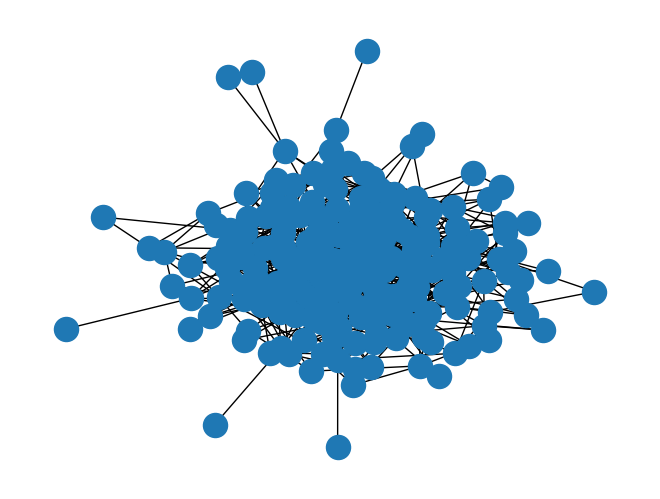

In [2]:
g = nx.erdos_renyi_graph(5000, 0.0002)
h = nx.erdos_renyi_graph(5000, 0.002)
g_small = nx.erdos_renyi_graph(200, 0.03)
print(g_small)
nx.draw(g_small)

In [3]:
print(len(list(nx.connected_components(g)))) # Weakly connected
print(len(list(nx.connected_components(h)))) # Highly connected

2452
1


In [4]:
for (u, v, w) in g.edges(data=True):
    wt = np.random.normal(0, 0.1)**2
    w["weight"] = wt

for (u, v, w) in h.edges(data=True):
    wt = np.random.normal(0, 0.1)**2 # np.random.uniform(6)
    w["weight"] = wt

In [5]:
W = nx.adjacency_matrix(g)
G = gl.graph(W)
evals = G.eigen_decomp(k=2000, normalization='normalized', method="lowrank")

W2 = nx.adjacency_matrix(h)
G2 = gl.graph(W2)
evals2 = G2.eigen_decomp(k=2000, normalization='normalized', method="lowrank")

C:\Users\Kyler\miniconda3\envs\harmonic\Lib\site-packages\graphlearning\graph.py:126: RuntimeWarning: divide by zero encountered in power
  D = sparse.spdiags(d**p, 0, self.num_nodes, self.num_nodes)


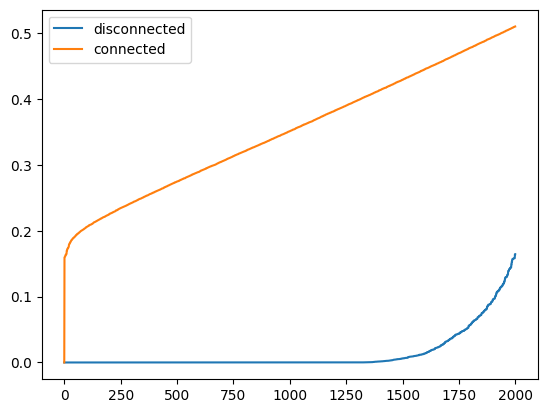

In [6]:
plt.plot(evals[0], label="disconnected")
plt.plot(evals2[0], label="connected")
plt.legend()
plt.show()

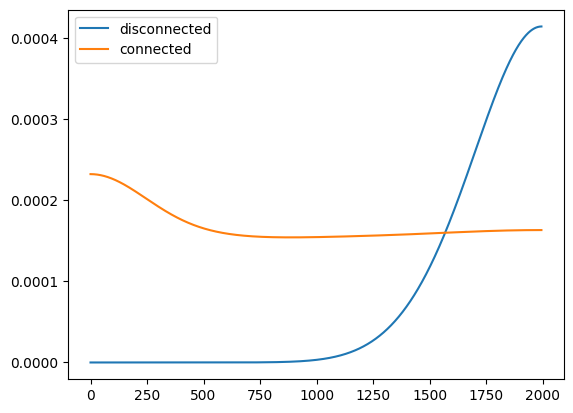

In [7]:
plt.plot(sg_derivative(evals[0].tolist()), label="disconnected")
plt.plot(sg_derivative(evals2[0].tolist()), label="connected")
plt.legend()
plt.show()

## Cell Images
Comparison to cell images. Graphs of cell images are fully connected and smaller eigenvalues come from the weakly-connected regions of the image (corresponding to sections of the image that are more weakly connected).

Graph is connected:  True


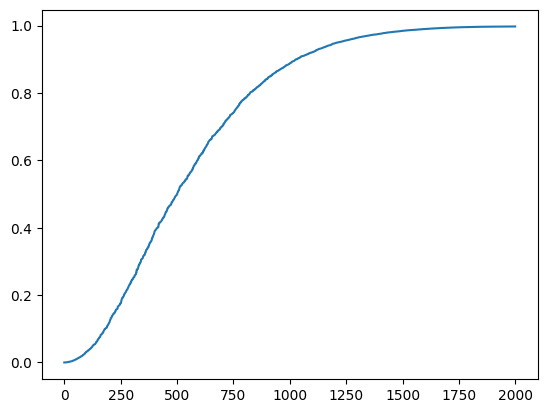

In [31]:
immat_dir = r"C:\Users\Kyler\Desktop\UROP\Data\Cell Data\immature_processed\edges"
im1 = Image.open(os.path.join(immat_dir, "iDC-2edge_smoothed.tif"))
ar1 = np.array(im1)
p1 = sample(ar1, N=5000)
evals_cell, evecs_cell = GFT(p1, r=2000)
plt.plot(evals_cell)

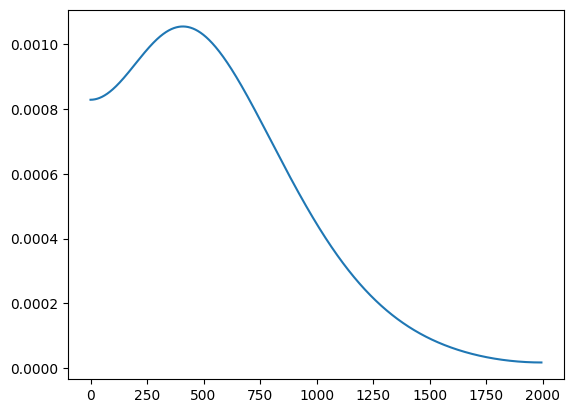

In [32]:
plt.plot(sg_derivative(evals_cell.tolist()))

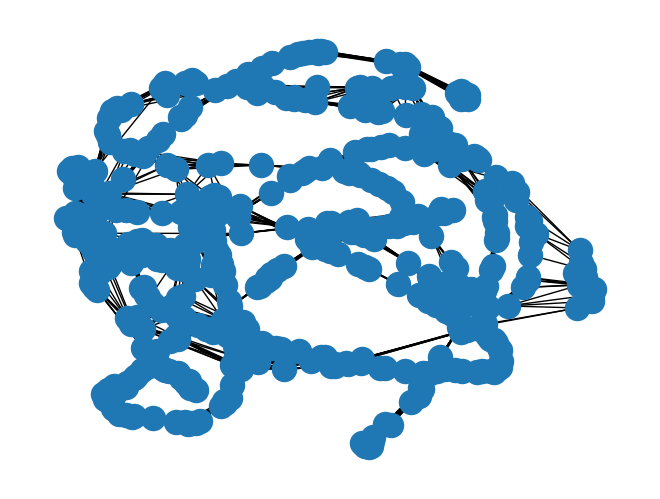

In [33]:
p2 = sample(ar1, N=500, normalize=False)
W1 = gl.weightmatrix.knn(p2, 10).todense()
np.fill_diagonal(W1, 0)
W1 = csr_array(W1)
G1 = nx.from_numpy_array(W1)
nx.draw(G1)

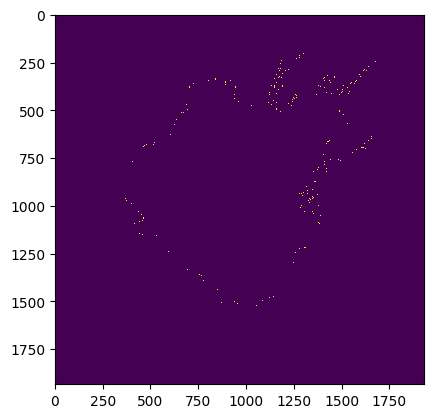

In [34]:
points = p1*1934 # unnormalized
sampled_ar = np.zeros(ar1.shape)
for pt in points:
    sampled_ar[int(pt[0]), int(pt[1])] = 255
plt.imshow(sampled_ar, interpolation="nearest")

### Cluster using Fiedler Vector, "Spectral Embeddings"

In [188]:
l = 3
cl_evals, cl_evecs = CLGFT(p1, r=2000, alpha=1.0)
fiedler_vecs = cl_evecs[:, 1:(l+1)]
fiedler_vecs

Graph is connected:  True


array([[ 0.05988158, -0.01332197, -0.05811454],
       [ 0.05406386, -0.01190659, -0.03711962],
       [ 0.02705896, -0.0355617 ,  0.04305938],
       ...,
       [ 0.00282154, -0.04745355,  0.09394672],
       [-0.04831849, -0.02936557, -0.02607271],
       [ 0.03995982,  0.05066218, -0.01256882]])

In [197]:
from sklearn.cluster import KMeans
kmeans_fit = KMeans(n_clusters=(2**l), n_init="auto")
kmeans_clusters = kmeans_fit.fit_predict(fiedler_vecs)
kmeans_clusters

array([5, 5, 2, ..., 2, 1, 0])

5000


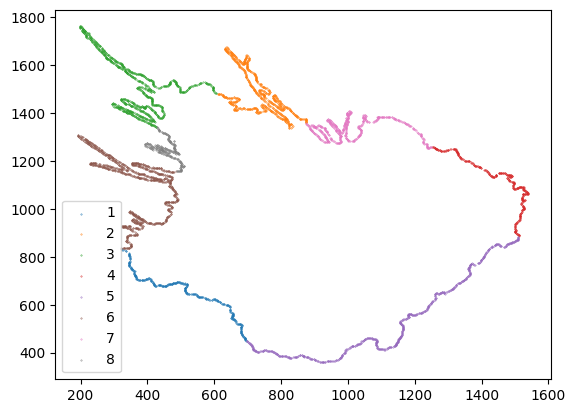

In [198]:
cluster_dict = dict()
for i in np.unique(kmeans_clusters):
    cluster_dict[i+1] = []
for i in range(len(kmeans_clusters)):
    label = kmeans_clusters[i] + 1
    cluster_dict[label].append(p1[i].tolist())
for k in cluster_dict.keys():
    c = np.array(cluster_dict[k]) * 1934 # resolution
    plt.scatter(c[:, 0], c[:, 1], label=k, s=0.1)
print(total_len)
plt.legend()
plt.show()

### Spectral Clustering from KNN Laplacian

In [191]:
from sklearn.cluster import SpectralClustering
sfit = SpectralClustering(affinity="precomputed_nearest_neighbors", n_neighbors=25)
W1 = gl.weightmatrix.knn(p1, 25)
spec_clusters = sfit.fit_predict(W1)
spec_clusters

C:\Users\Kyler\miniconda3\envs\harmonic\Lib\site-packages\sklearn\neighbors\_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


array([1, 1, 0, ..., 7, 3, 6])

5000


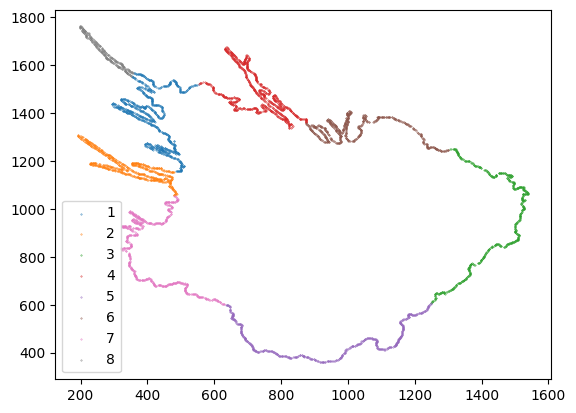

In [192]:
cluster_dict = dict()
for i in np.unique(spec_clusters):
    cluster_dict[i+1] = []
for i in range(len(spec_clusters)):
    label = spec_clusters[i] + 1
    cluster_dict[label].append(p1[i].tolist())
for k in cluster_dict.keys():
    c = np.array(cluster_dict[k]) * 1934 # resolution
    plt.scatter(c[:, 0], c[:, 1], label=k, s=0.1)
print(total_len)
plt.legend()
plt.show()

## Random Geometric Graphs
Generate data from a distribution and weight based on this. 

In [142]:
N = 5000
k = 25
#g = nx.gnm_random_graph(N,(N*k)//np.sqrt(2))

g = nx.thresholded_random_geometric_graph(5000, 2, 8) # TRY POS/OTHER PARAMS

h = g.copy()
print(g)
# Add a random number of small connected trees (the spindles) and see what happens to the eigenvalues

Graph named 'thresholded_random_geometric_graph(5000, 2, 7, 2)' with 5000 nodes and 78818 edges


In [120]:
largest_cc = max(nx.connected_components(g), key=len)
s = g.subgraph(largest_cc).copy()
#nx.draw(s)
h = s.copy()
g = s.copy()

# Synthetic Patterns
Random geometric graphs e.g. using mixture of Gaussians